<h1><center><b>Petal Detection</b></center></h1>

## Importing Libraries

In [1]:
import os, random, re, math
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.model_selection import KFold
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
%matplotlib inline
print('TensorFlow version',tf.__version__)

TensorFlow version 2.2.0


## Configuration

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ',tpu.master())
except ValueError:
    tpu = None
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
AUTO = tf.data.experimental.AUTOTUNE

#Model config
IMAGE_SIZE = [224,224]
EPOCHS = 15
SEED = 50
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

## Mixed Precision & XLA for speed up

The following booleans can enable mixed precision and/or XLA on GPU/TPU. By default TPU already uses some mixed precision but we can add more. These allow the GPU/TPU memory to handle larger batch sizes and can speed up the training process. The Nvidia V100 GPU has special Tensor Cores which get utilized when mixed precision is enabled. Unfortunately Kaggle's Nvidia P100 GPU does not have Tensor Cores to receive speed up.

In [4]:
MIXED_PRECISION = True
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Mixed precision enabled
Accelerated Linear Algebra enabled


## Data Directories

In [5]:
DATA_DIR = KaggleDatasets().get_gcs_path('tpu-getting-started')

In [6]:
#Data dictionary according to image size 
DATA_IMG_DIR = {
    192: DATA_DIR + '/tfrecords-jpeg-192x192',
    331: DATA_DIR + '/tfrecords-jpeg-331x331',
    224: DATA_DIR + '/tfrecords-jpeg-224x224',
    512: DATA_DIR + '/tfrecords-jpeg-512x512'
}

In [7]:
#Files list for train,val,test
path = DATA_IMG_DIR[IMAGE_SIZE[0]]

TRAIN_FILES = tf.io.gfile.glob(path + '/train/*.tfrec')
VAL_FILES = tf.io.gfile.glob(path + '/val/*.tfrec')
TEST_FILES = tf.io.gfile.glob(path + '/test/*.tfrec')

In [8]:
#Classes
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 103

## Custom LR

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


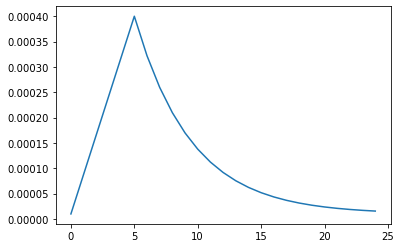

In [9]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Utility Functions

In [10]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABEL_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABEL_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABEL_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABEL_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO)
    return dataset

## Data Augumentation

In [11]:
def aug(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    
    #convert degree to radian
    rotation = math.pi * rotation / 180.0
    shear = math.pi * shear / 180.0
    
    #rotation matrix
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1,s1,zero,-s1,c1,zero,zero,zero,one], axis=0), [3,3])
    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])
    
    #zoom matrix
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3])
    
    #shift matrix
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image, label):
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32')
    
    #get transformation matrix
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift)
    
    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

## Load Datasets

In [12]:
def get_train_dataset(dataset, do_aug=True):
    dataset = dataset.map(aug, num_parallel_calls=AUTO)
    if do_aug:
        dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_val_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [13]:
TRAIN_IMAGES = int(count_data_items(TRAIN_FILES))
VAL_IMAGES = int(count_data_items(VAL_FILES))
TEST_IMAGES = int(count_data_items(TEST_FILES))

print('Dataset has {} training images, {} validation images, {} testing images'.format(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES))

Dataset has 12753 training images, 3712 validation images, 7382 testing images


## Augumentation Example

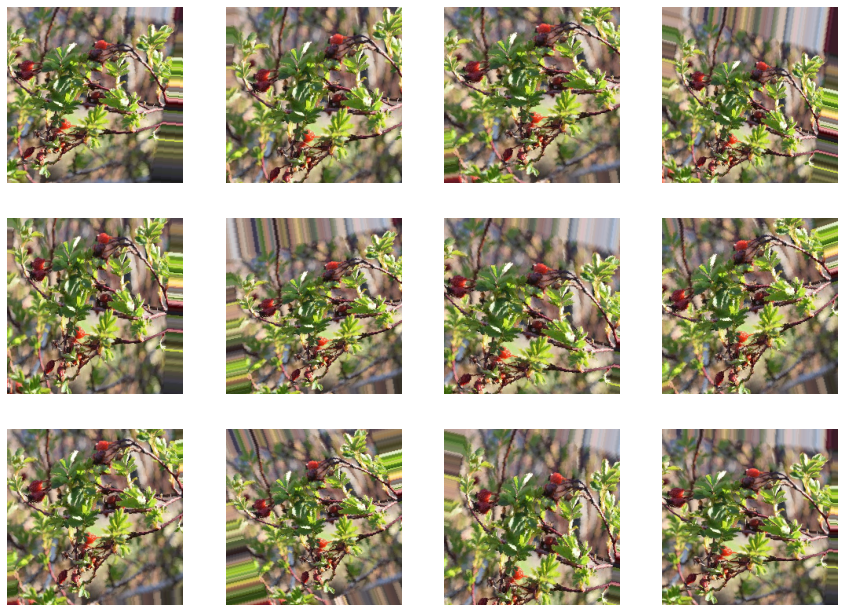

In [14]:
row = 3; col = 4;
all_elements = get_train_dataset(load_dataset(TRAIN_FILES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break
del all_elements
del one_element

## Model building

In [15]:
from tensorflow.keras.applications import DenseNet201

def get_model():
    with strategy.scope():
        rnet = DenseNet201(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def train_model():
    train_dataset = load_dataset(list(pd.DataFrame({'TRAIN_FILES': TRAIN_FILES})['TRAIN_FILES']), labeled=True)
    val_dataset = load_dataset(list(pd.DataFrame({'VAL_FILES': VAL_FILES})['VAL_FILES']), labeled=True, ordered=True)
    model = get_model()
    print(model.summary())
    history = model.fit(get_train_dataset(train_dataset),
                        steps_per_epoch = TRAIN_IMAGES // BATCH_SIZE,
                        epochs = EPOCHS,
                        validation_data = get_val_dataset(val_dataset),
                        callbacks = [lr_callback],
                        verbose = 1)
    return model, history

def predict(model):
    test_dataset = get_test_dataset(ordered=True)
    test_image_ds = test_dataset.map(lambda image, idnum: image)
    prob = model.predict(test_image_ds)
    pred = np.argmax(prob, axis=-1)
    print('Generating submission file.....')
    test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(TEST_IMAGES))).numpy().astype('U') # all in one batch
    np.savetxt('submission.csv', np.rec.fromarrays([test_ids, pred]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    return

In [16]:
K.clear_session()

## Training the model

In [17]:
model, history = train_model()

74842112/74836368 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________
None

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
49/49 [==============================] - 49s 994ms/step - loss: 4.6607 - sparse_catego

## Plotting Results

### Plot for accuracy

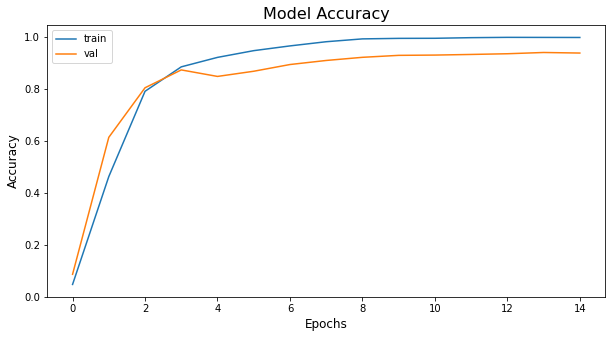

In [18]:
plt.figure(figsize=(10,5))
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.legend(['train','val'], loc=0)
plt.show()

### Plot for loss

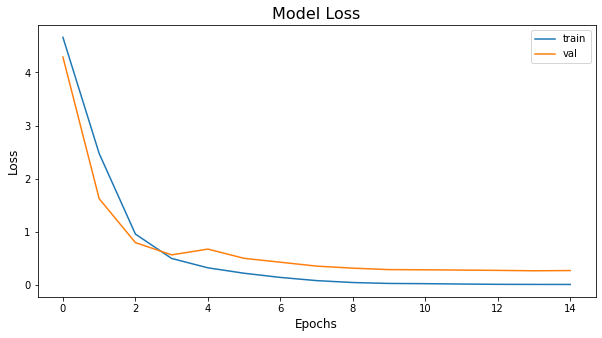

In [19]:
plt.figure(figsize=(10,5))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.legend(['train','val'], loc=0)
plt.show()

From the plots we can easily see our model started overfitting after initial epochs.

### Plot for Loss vs Lr

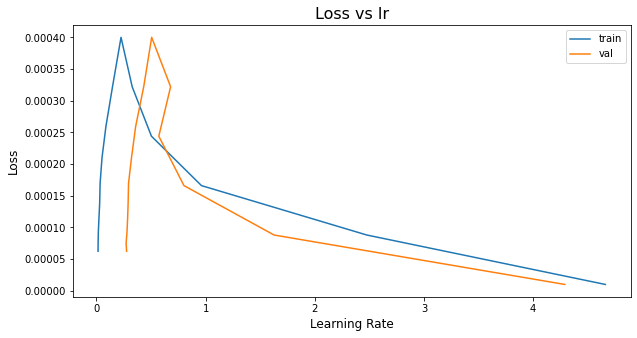

In [20]:
plt.figure(figsize=(10,5))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
lr = history.history['lr']
plt.plot(train_loss, lr)
plt.plot(val_loss, lr)
plt.title('Loss vs lr', fontsize=16)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Learning Rate', fontsize=12)
plt.legend(['train','val'], loc=0)
plt.show()

### Plotting Confusion metric

In [21]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

In [22]:
val_dataset = list(pd.DataFrame({'VAL_FILES': VAL_FILES})['VAL_FILES'])
cmdataset = get_val_dataset(load_dataset(val_dataset, labeled = True, ordered = True))
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
labels_ds =  next(iter(labels_ds.batch(VAL_IMAGES))).numpy() # get everything as one batch
prob = model.predict(images_ds)
pred = np.argmax(prob, axis=-1)

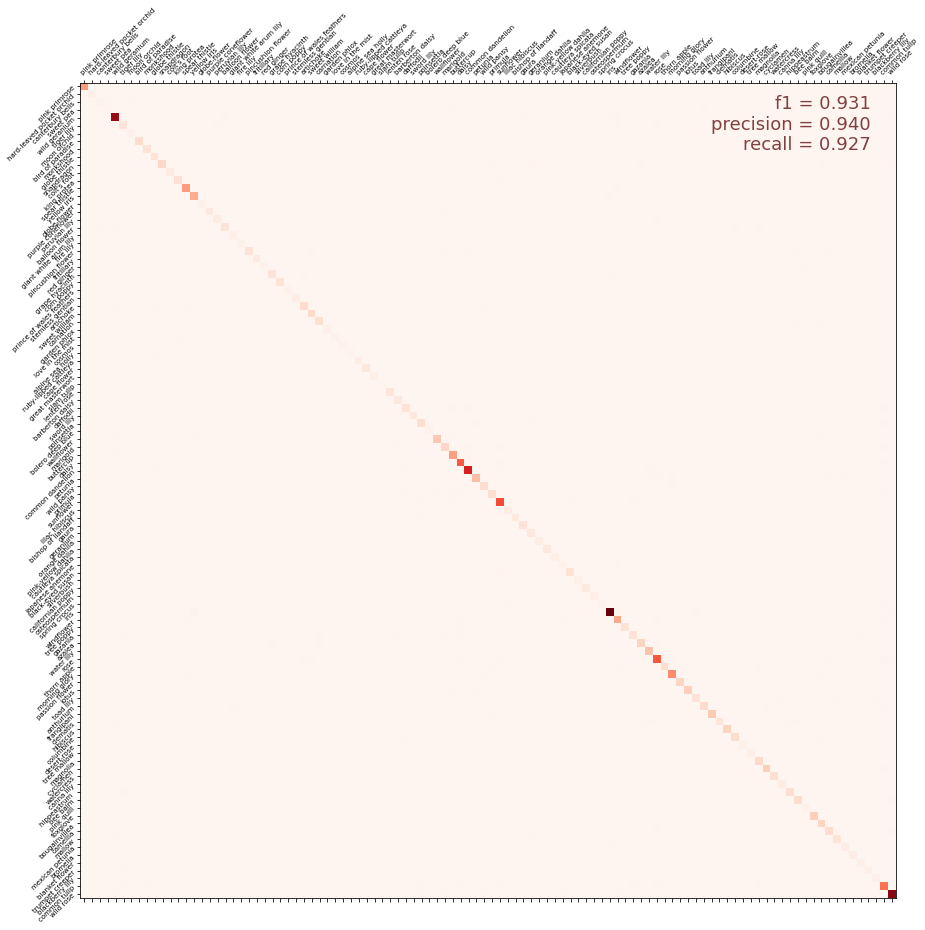

f1 score: 0.931, precision: 0.940, recall: 0.927



In [23]:
cmat = metrics.confusion_matrix(labels_ds, pred, labels=range(len(CLASSES)))
score = metrics.f1_score(labels_ds, pred, labels=range(len(CLASSES)), average='macro')
precision = metrics.precision_score(labels_ds, pred, labels=range(len(CLASSES)), average='macro')
recall = metrics.recall_score(labels_ds, pred, labels=range(len(CLASSES)), average='macro')
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall)); print()

## Predicting on test data

In [24]:
predict(model)

Generating submission file.....


## Saving model

In [26]:
model.save('simple_model.h5')
print('model saved')

model saved


## KFold Training

Since as we saw that our model was overfitting. So, we will now use a 3-fold training with 5-fold cross validation to train our model for better scores

In [27]:
FOLDS = 3
EPOCHS = 10

In [28]:
K_TRAIN_FILES = tf.io.gfile.glob(path + '/train/*.tfrec') + tf.io.gfile.glob(path + '/val/*.tfrec')

In [29]:
TRAIN_IMAGES = int( count_data_items(K_TRAIN_FILES) * (FOLDS-1.)/FOLDS )
VAL_IMAGES = int( count_data_items(K_TRAIN_FILES) * (1./FOLDS) )
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(TRAIN_IMAGES,
                                                                                           VAL_IMAGES, TEST_IMAGES))

Dataset: 10976 training images, 5488 validation images, 7382 unlabeled test images


In [35]:
def K_fold_training(folds = 5):
    histories = []
    models = []
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
    kfold = KFold(folds, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(K_TRAIN_FILES)):
        print(); print('#'*25)
        print('### FOLD', f+1)
        print('#'*25)
        
        train_dataset = load_dataset(list(pd.DataFrame({'K_TRAIN_FILES': K_TRAIN_FILES}).loc[trn_ind]['K_TRAIN_FILES']), labeled = True)
        val_dataset = load_dataset(list(pd.DataFrame({'K_TRAIN_FILES': K_TRAIN_FILES}).loc[val_ind]['K_TRAIN_FILES']), labeled = True, ordered = True)
        
        model = get_model()
        history = model.fit(
            get_train_dataset(train_dataset), 
            steps_per_epoch = TRAIN_IMAGES // BATCH_SIZE,
            epochs = EPOCHS,
            callbacks = [lr_callback],
            validation_data = get_val_dataset(val_dataset),
            verbose=1
        )
        models.append(model)
        histories.append(history)
    return models, histories

In [31]:
K.clear_session()

In [32]:
models, histories = K_fold_training(folds = FOLDS)


#########################
### FOLD 1
#########################

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
42/42 [==============================] - 47s 1s/step - loss: 4.6972 - sparse_categorical_accuracy: 0.0388 - val_loss: 4.3848 - val_sparse_categorical_accuracy: 0.0725 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/10
42/42 [==============================] - 10s 247ms/step - loss: 2.7150 - sparse_categorical_accuracy: 0.4242 - val_loss: 1.8303 - val_sparse_categorical_accuracy: 0.5855 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/10
42/42 [==============================] - 11s 264ms/step - loss: 1.1556 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.8920 - val_sparse_categorical_accuracy: 0.7812 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/10
42/42 [==============================] - 11s 268ms

42/42 [==============================] - 12s 285ms/step - loss: 0.0346 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.3392 - val_sparse_categorical_accuracy: 0.9158 - lr: 1.6974e-04


In [36]:
t = models
models = histories
histories = t

## Predicting K-fold

In [37]:
def K_predict(models, folds=5):
    test_ds = get_test_dataset(ordered=True) 
    test_images_ds = test_ds.map(lambda image, idnum: image)
    # get the mean probability of the folds models
    probabilities = np.average([models[i].predict(test_images_ds) for i in range(folds)], axis = 0)
    predictions = np.argmax(probabilities, axis=-1)
    print('Generating submission.csv file...')
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(TEST_IMAGES))).numpy().astype('U') # all in one batch
    np.savetxt('K-submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    return

In [38]:
K_predict(models, FOLDS)

Generating submission.csv file...


## Plotting Confusion matrix

In [40]:
%%time
all_labels = []; all_prob = []; all_pred = []
kfold = KFold(FOLDS, shuffle = True, random_state = SEED)
for j, (trn_ind, val_ind) in enumerate( kfold.split(K_TRAIN_FILES) ):
    print('Inferring fold',j+1,'validation images...')
    val_dataset = list(pd.DataFrame({'K_TRAIN_FILES': K_TRAIN_FILES}).loc[val_ind]['K_TRAIN_FILES'])
    VAL_IMAGES = count_data_items(val_dataset)
    cmdataset = get_val_dataset(load_dataset(val_dataset, labeled = True, ordered = True))
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    all_labels.append( next(iter(labels_ds.batch(VAL_IMAGES))).numpy() ) # get everything as one batch
    prob = models[j].predict(images_ds)
    all_prob.append( prob )
    all_pred.append( np.argmax(prob, axis=-1) )
cm_correct_labels = np.concatenate(all_labels)
cm_probabilities = np.concatenate(all_prob)
cm_predictions = np.concatenate(all_pred)

Inferring fold 1 validation images...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7fef7caa63b0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function <lambda> at 0x7fefe83525f0>. Note that functions defined in certain environments, l

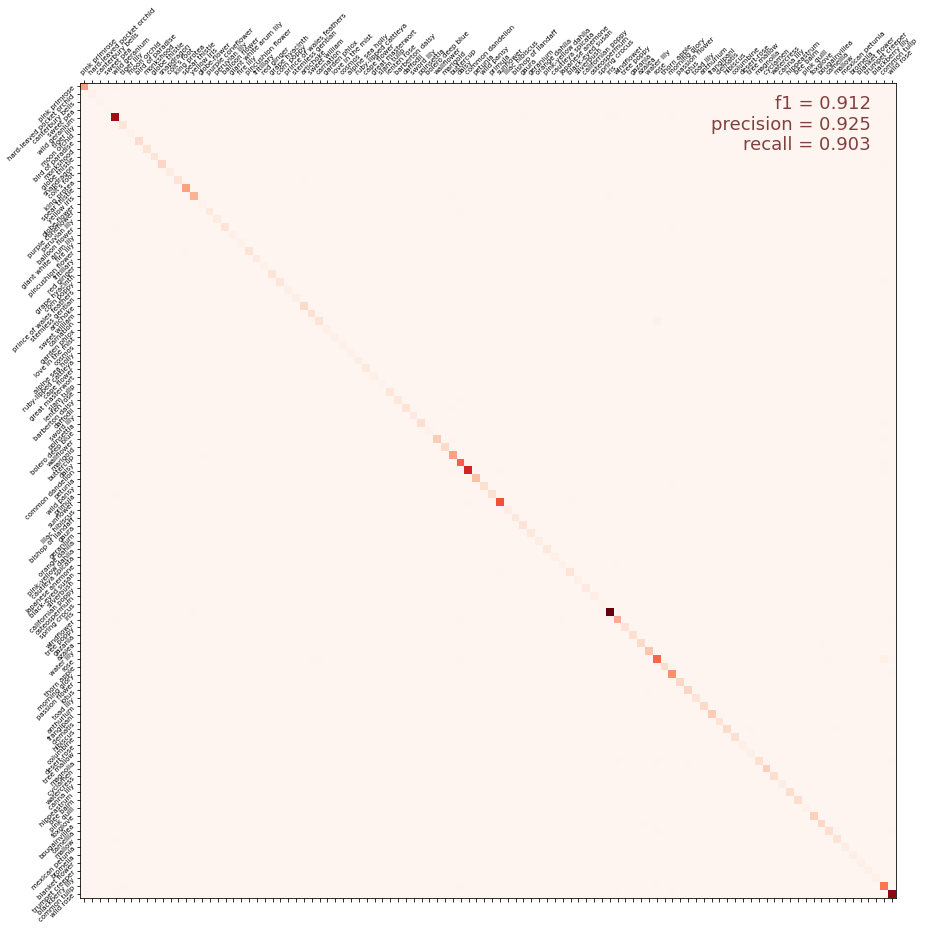

f1 score: 0.912, precision: 0.925, recall: 0.903



In [42]:
cmat = metrics.confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = metrics.f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = metrics.precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = metrics.recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall)); print()